<a href="https://colab.research.google.com/github/rjthompson22/MBSUS_SS-GAN/blob/main/SS_GAN_224x224.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notes
Accuracy would not increase. Needs to be investigated.

Potentially the Iter method for calling labeled training samples.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
print("Complete")

Mounted at /content/gdrive
Complete


In [ ]:
from __future__ import print_function, division

import random
from random import shuffle

import numpy as np
import matplotlib.pyplot as plt
import copy

import os
from os import listdir
from os.path import join

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.utils as vutils
from torchvision import utils, models

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)
random.seed(10)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(999)

device = torch.device("cuda")

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms, datasets
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)
import os
import cv2
import numpy as np
from PIL import Image
print("Complete")

Complete


In [ ]:
import os
import pathlib

import torch
from PIL import Image


class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, root: str, folder: str, klass: int, extension: str = "png"):
        self._data = pathlib.Path(root) / folder
        self.klass = klass
        self.extension = extension
        # Only calculate once how many files are in this folder
        # Could be passed as argument if you precalculate it somehow
        # e.g. ls | wc -l on Linux
        self._length = sum(1 for entry in os.listdir(self._data))

    def __len__(self):
        # No need to recalculate this value every time
        return self._length

    def __getitem__(self, index):
        # images always follow [0, n-1], so you access them directly
        return Image.open(self._data / "{}.{}".format(str(index), self.extension))

In [ ]:
img_dir = '/content/gdrive/My Drive/MBSUS/Training+Testing/Training'
unsup_dir = '/content/gdrive/MyDrive/MBSUS/All Ultrasound Frames'
batch_size = 100
resize = 224

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                transforms.Resize((resize,resize),interpolation=Image.NEAREST),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.RandomHorizontalFlip(p=0.5)
])
dataset = datasets.ImageFolder(img_dir, transform=transform)
print(dataset.class_to_idx)

len_train = round(len(dataset)*0.7)
len_val = round(len(dataset)*0.2)
len_test = round(len(dataset)*0.1)

train_set, val_set, test_set = torch.utils.data.random_split(dataset, [len_train, len_val, len_test])



train_loader = DataLoader(
    train_set,
    batch_size = batch_size,
    shuffle = True
)

val_loader = DataLoader(
    val_set,
    batch_size = batch_size,
    shuffle = True
)

test_loader = DataLoader(
    test_set,
    batch_size = batch_size,
    shuffle = True
)

unsup_dataset = datasets.ImageFolder(unsup_dir, transform=transform)
len_unsup = round(len(unsup_dataset)*0.08)
rest_unsup = round(len(unsup_dataset)*0.92)
unsup_set, _ = torch.utils.data.random_split(unsup_dataset, [len_unsup, rest_unsup])

batches = len(train_set)/batch_size
unsup_batch_size = int(len(unsup_set)/batches)

unsup_loader = DataLoader(
    unsup_set,
    batch_size = unsup_batch_size,
    shuffle = True
)

print("Number of Unsupervised Samples: %d" %len_unsup)
print("Number of pics per Unsup Batch: %d" %unsup_batch_size)
print("Number of UnSup Batches: %d" %(len_unsup//unsup_batch_size))

{'Non-Pneumonia': 0, 'Pneumonia': 1}
Number of Unsupervised Samples: 5629
Number of pics per Unsup Batch: 373
Number of UnSup Batches: 15


In [ ]:
# Use a (not pre-trained) ResNet18 with d_out = 2 as the Classifier
classifier = models.resnet18(pretrained=False)
classifier.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
num_ftrs = classifier.fc.in_features
classifier.fc = nn.Linear(num_ftrs, 2)
classifier = classifier.to(device)

optimizerC = optim.SGD(classifier.parameters(), lr=0.001, momentum=0.9, dampening=0, weight_decay=0.0001)

In [ ]:
def test(model, device, test_loader, m_test, display = False, verdicts = False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for _, batch in enumerate(test_loader):
            data, target = batch
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() 
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            if verdicts == True:
              for i in range(len(pred)):
                t = target.view_as(pred)[i].item()
                if pred[i].item() == target.view_as(pred)[i].item():
                  plt.imshow(data[i].to('cpu').squeeze(0))
                  plt.title("%d" %t)
                  plt.show()

    test_loss /= m_test

    if display == True:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, m_test,
        100. * correct / m_test))
        
    # test_loader.reset()    
    return test_loss, 100. * correct / m_test

In [ ]:
# custom weights initialization called on the Generator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

# Number of channels in the training images. For color images this is 3
nc = 1
# Size of z latent vector 
nz = 100
# Size of feature maps in generator
ngf = 64


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*4) x 7 x 7
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*4) x 7 x 7
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 14 x 14
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 28 x 28
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 56 x 56
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 112 x 112
        )

    def forward(self, input):
      return self.main(input)
    
# A noise vector to be used for generating images at the end of each training epoch
fixed_noise = torch.randn(9, nz, 1, 1, device=device)

netG = Generator().to(device)
netG.apply(weights_init)

optimizerG = optim.Adam(netG.parameters(), lr=0.002, betas= (0.5, 0.999))

In [ ]:
def log_sum_exp(x, axis = 1):
    m = torch.max(x, dim = 1)[0]
    return m + torch.log(torch.sum(torch.exp(x - m.unsqueeze(1)), dim = axis))
    
val_losses = []
val_accuracies = []

best_model_wts = copy.deepcopy(classifier.state_dict())
best_acc = 0.0
criterion = nn.CrossEntropyLoss()
epochs = 100



Test set: Average loss: 0.0289, Accuracy: 347/431 (81%)



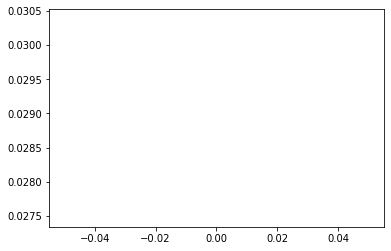

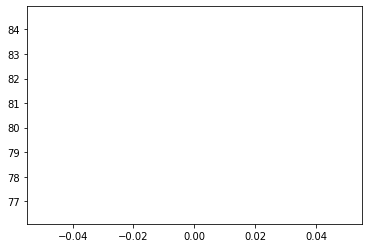



Test set: Average loss: 25.0248, Accuracy: 274/431 (64%)



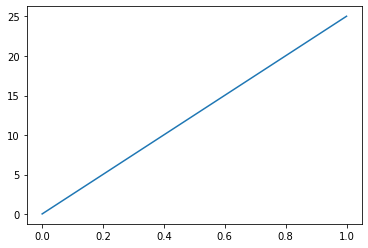

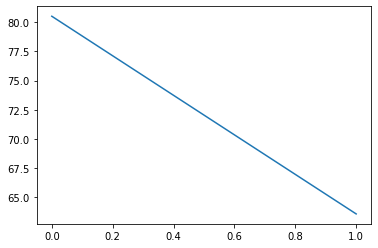



Test set: Average loss: 0.1777, Accuracy: 157/431 (36%)



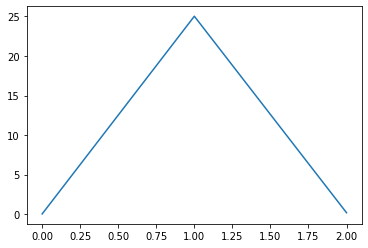

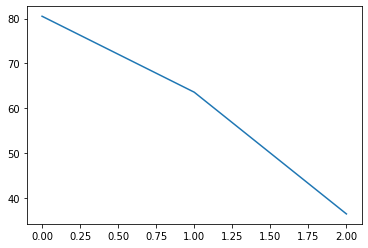



Test set: Average loss: 201.4536, Accuracy: 274/431 (64%)



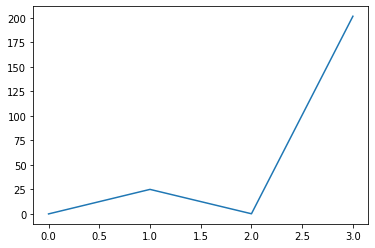

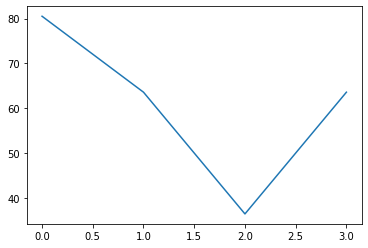



Test set: Average loss: 2.2256, Accuracy: 274/431 (64%)



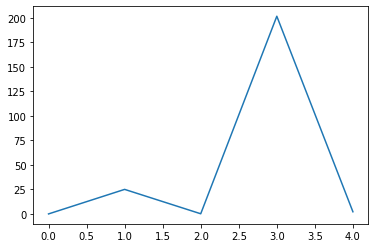

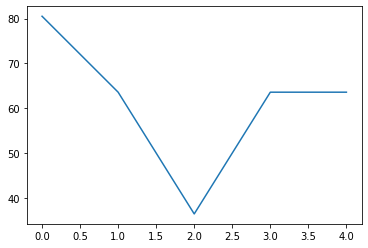



Test set: Average loss: 10.7028, Accuracy: 274/431 (64%)



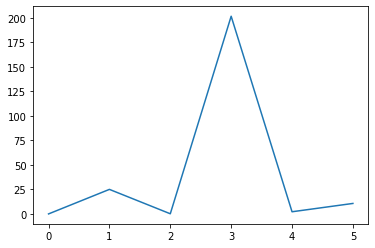

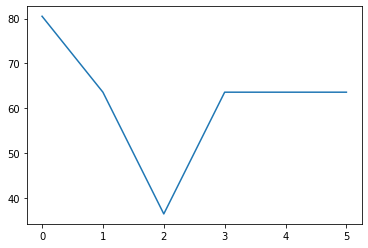



Test set: Average loss: 7.3774, Accuracy: 274/431 (64%)



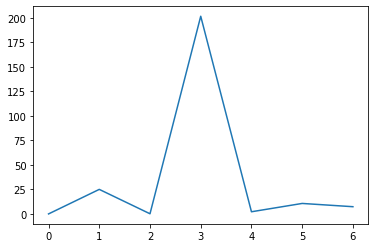

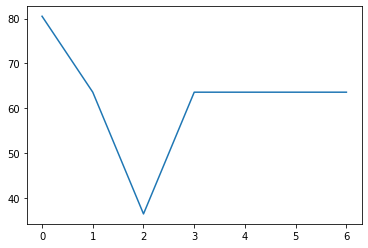



Test set: Average loss: 252.6530, Accuracy: 274/431 (64%)



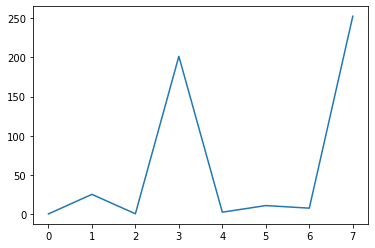

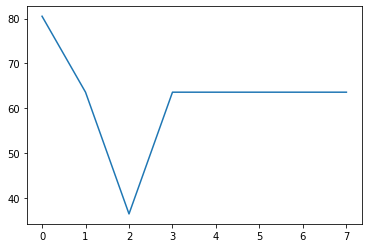



Test set: Average loss: 9.7216, Accuracy: 274/431 (64%)



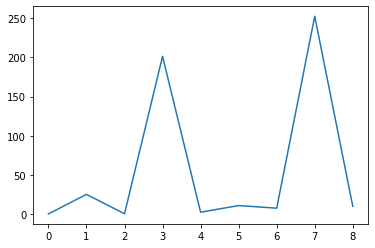

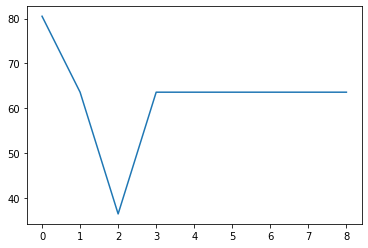



Test set: Average loss: 0.0085, Accuracy: 206/431 (48%)



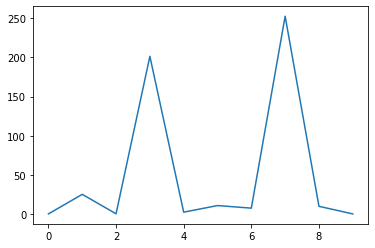

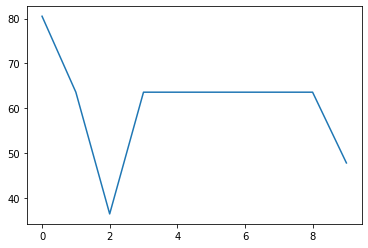



Test set: Average loss: 0.0077, Accuracy: 260/431 (60%)



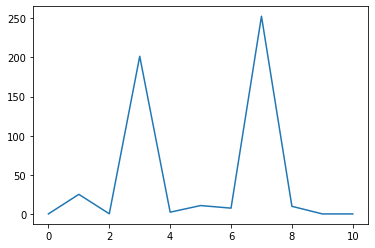

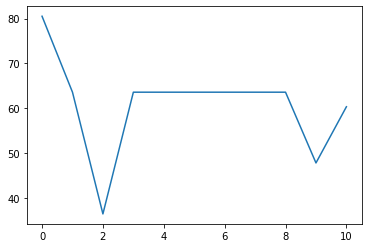



Test set: Average loss: 0.0079, Accuracy: 193/431 (45%)



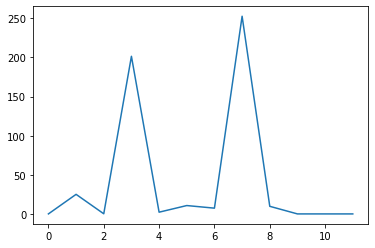

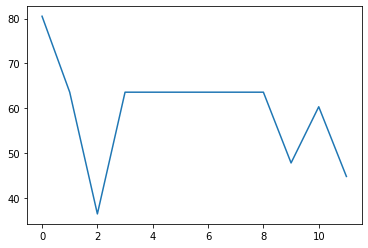



Test set: Average loss: 0.0073, Accuracy: 264/431 (61%)



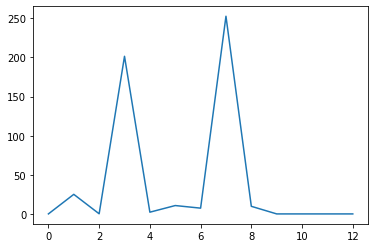

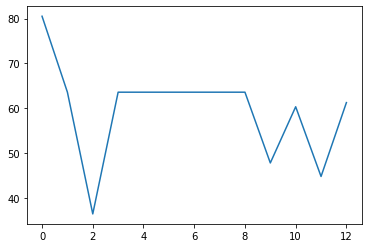



Test set: Average loss: 0.0075, Accuracy: 275/431 (64%)



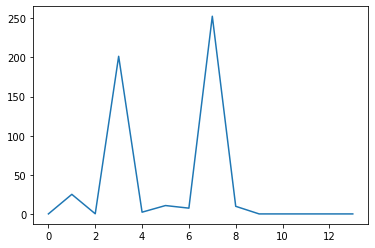

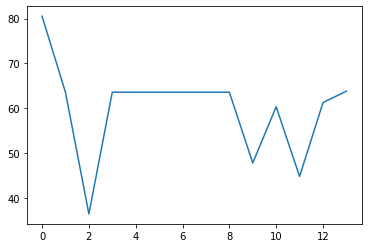



Test set: Average loss: 0.0080, Accuracy: 211/431 (49%)



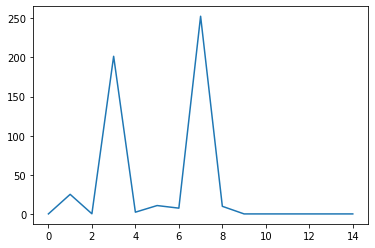

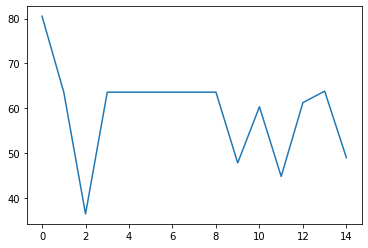



Test set: Average loss: 0.0072, Accuracy: 234/431 (54%)



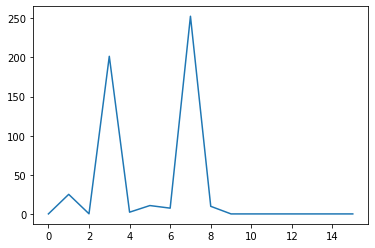

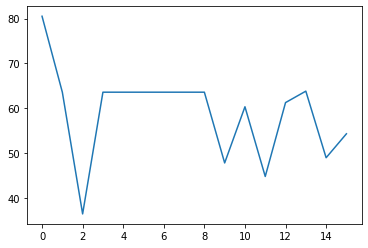



Test set: Average loss: 0.0082, Accuracy: 209/431 (48%)



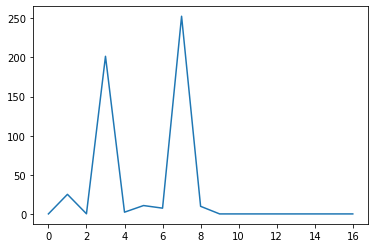

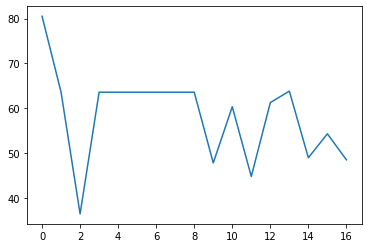



Test set: Average loss: 0.0072, Accuracy: 239/431 (55%)



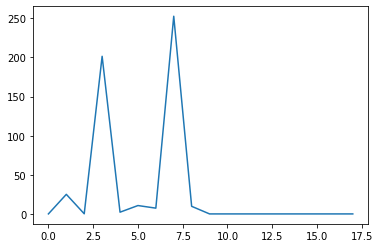

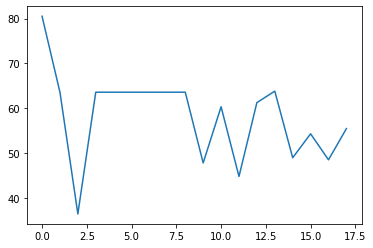



Test set: Average loss: 0.0073, Accuracy: 261/431 (61%)



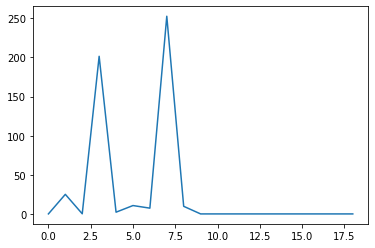

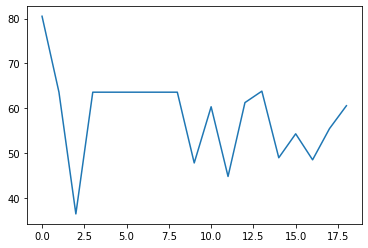



Test set: Average loss: 0.0077, Accuracy: 241/431 (56%)



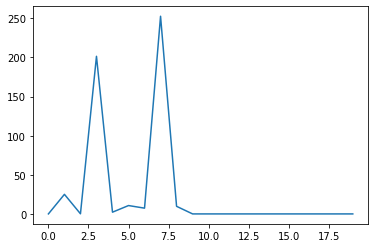

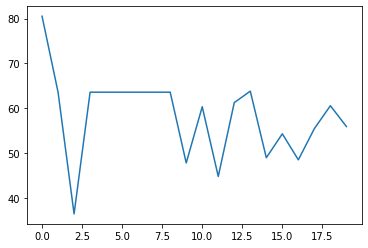



Test set: Average loss: 0.0071, Accuracy: 273/431 (63%)



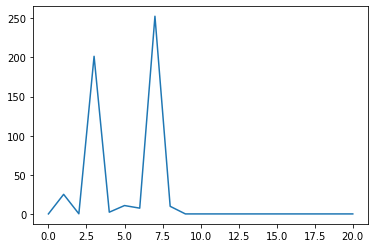

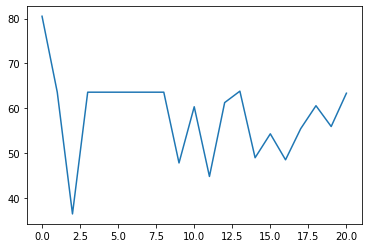



Test set: Average loss: 0.0075, Accuracy: 238/431 (55%)



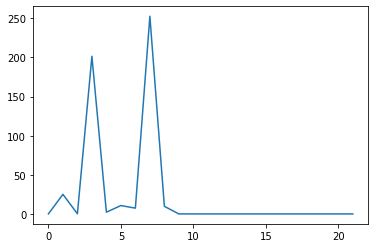

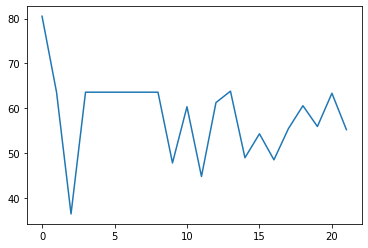



Test set: Average loss: 0.0072, Accuracy: 273/431 (63%)



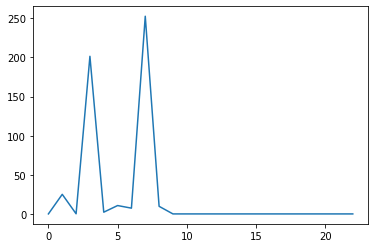

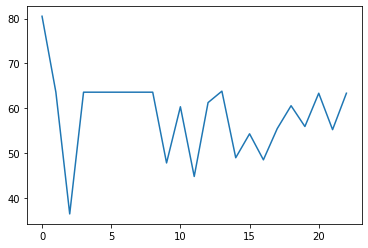



Test set: Average loss: 0.0063, Accuracy: 288/431 (67%)



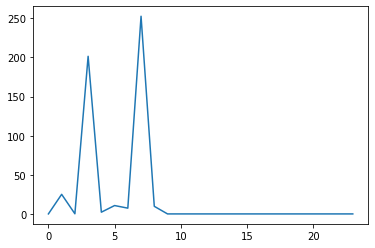

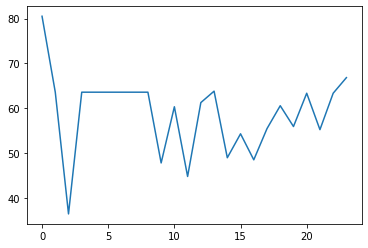



Test set: Average loss: 0.0071, Accuracy: 273/431 (63%)



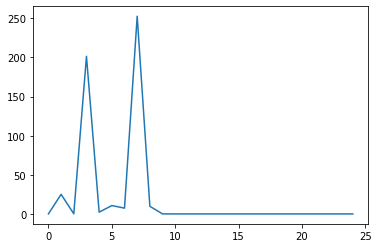

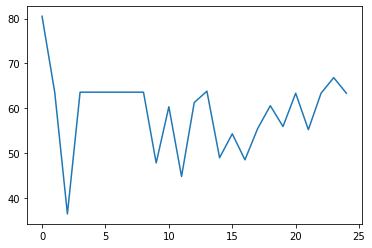



Test set: Average loss: 0.0059, Accuracy: 318/431 (74%)



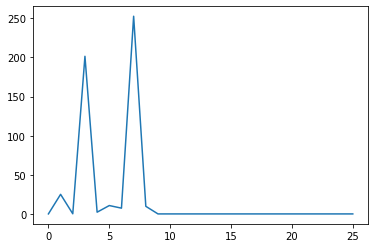

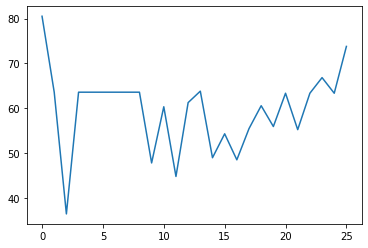



Test set: Average loss: 0.0065, Accuracy: 284/431 (66%)



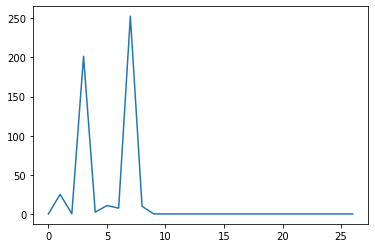

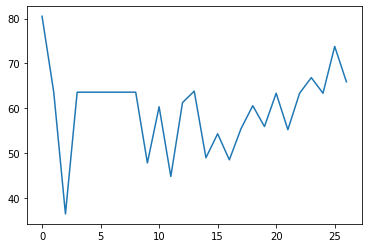



Test set: Average loss: 0.0063, Accuracy: 312/431 (72%)



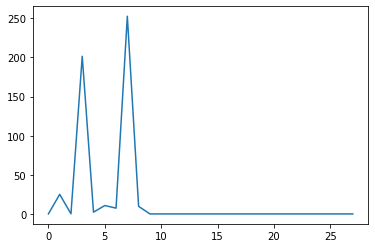

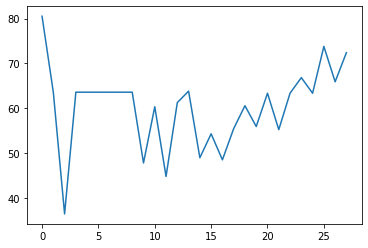



Test set: Average loss: 0.0060, Accuracy: 313/431 (73%)



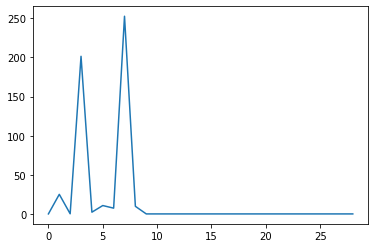

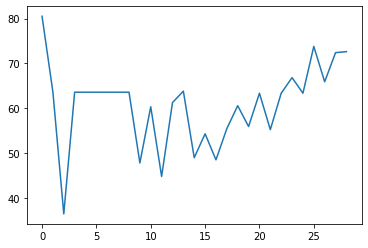



Test set: Average loss: 0.0068, Accuracy: 284/431 (66%)



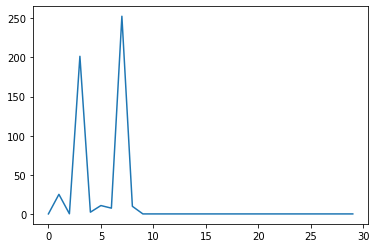

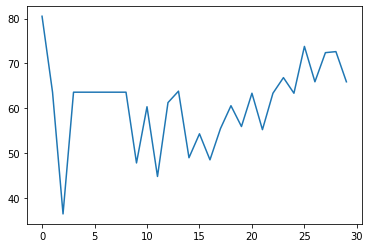



Test set: Average loss: 0.0065, Accuracy: 331/431 (77%)



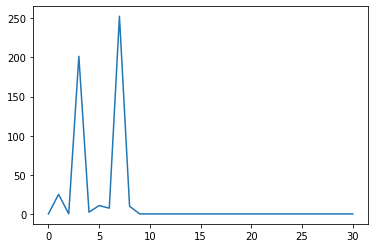

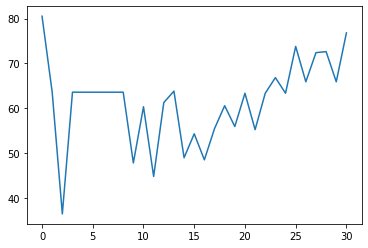

In [ ]:
epochs = 200
for epoch in tqdm(range(1, epochs + 1), desc = "Total Training Progress"):

    for unsup_data, _ in tqdm(unsup_loader, desc="Epoch %d: Training on Unlabeled Data" % epoch):
        
        # TRAIN THE DISCRIMINATOR (THE CLASSIFIER)
        classifier.train()
        optimizerC.zero_grad()
        
        # 1. on Unlabelled data
        unsup_data = unsup_data.to(device)        
        outputs = classifier(unsup_data)    
        logz_unlabel = log_sum_exp(outputs)
        lossUL = 0.5 * (-torch.mean(logz_unlabel) + torch.mean(F.softplus(logz_unlabel)))
        lossUL.backward()  
        
        # 2. on the generated data

        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        generated = (netG(noise)+1.0)/2.0
        outputs = classifier(generated.detach()) # detach() because we are not training G here
        logz_fake = log_sum_exp(outputs)
        lossD = 0.5*torch.mean(F.softplus(logz_fake))
        lossD.backward()

        optimizerC.step()
        
        # TRAIN THE GENERATOR
        netG.train()
        optimizerG.zero_grad()
        
        outputs = classifier(generated)
        logz_unlabel = log_sum_exp(outputs)
        lossG = 0.5 * (-torch.mean(logz_unlabel) + torch.mean(F.softplus(logz_unlabel)))
        lossG.backward()
        optimizerG.step()

    for labeled_data, labels in tqdm(train_loader, desc="Epoch %d: Training on Labeled Data" % epoch):
        # 3. on labeled data
        labeled_data, labels = labeled_data.to(device), labels.to(device)
        output = classifier(labeled_data)
        logz_label = log_sum_exp(output)
        prob_label = torch.gather(output, 1, labels.unsqueeze(1))
        labeled_loss = -torch.mean(prob_label) + torch.mean(logz_label)
        labeled_loss.backward()    

        optimizerC.step()
        

            
    
    # generated = (netG(fixed_noise)+1.0)/2.0
    # vutils.save_image(generated.cpu().detach(), 
    #                   ('/content/gdrive/MyDrive/MBSUS/Training+Testing/Generated Images/generated_28x28_%d.jpg' % epoch), normalize=True)
    
    val_loss, val_accuracy = test(classifier, device, val_loader, len_val, True)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
        
    if val_accuracy > best_acc:
        best_acc = val_accuracy
        best_classifier_wts = copy.deepcopy(classifier.state_dict())

    plt.plot(range(len(val_losses)), np.array(val_losses), label = "Val Loss")
    plt.show()
    plt.plot(range(len(val_accuracies)), np.array(val_accuracies), label = "Val Accuracies")
    plt.show()

print('Best VAL test accuracy: ', np.max(np.array(val_accuracies)),
      '% after ', np.argmax(np.array(val_accuracies)), ' training epochs')

# load best model weights
classifier.load_state_dict(best_classifier_wts)

print("\nBest model on the test set: ")
test(classifier, device, test_loader, len_test, True)   



Test set: Average loss: 0.1140, Accuracy: 167/317 (53%)



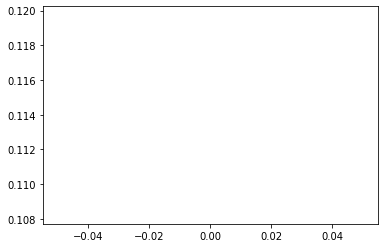

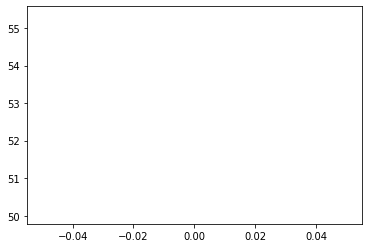



Test set: Average loss: 0.2068, Accuracy: 150/317 (47%)



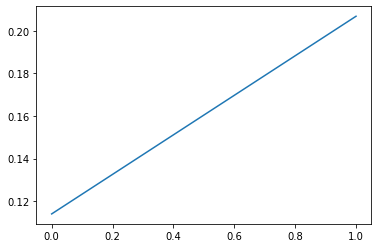

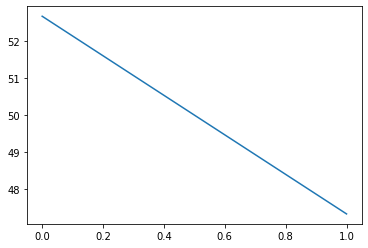



Test set: Average loss: 0.7685, Accuracy: 150/317 (47%)



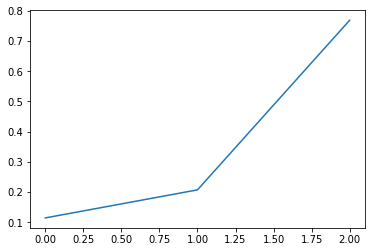

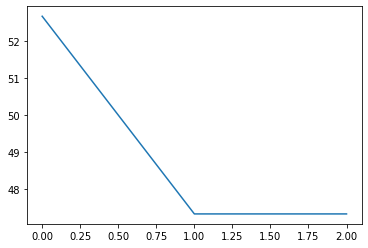



Test set: Average loss: 1.1638, Accuracy: 150/317 (47%)



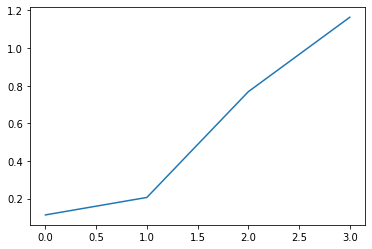

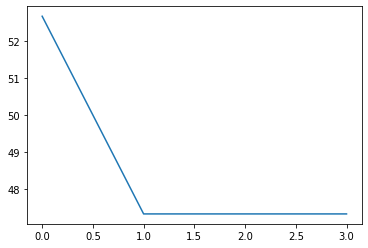



Test set: Average loss: 1.4950, Accuracy: 150/317 (47%)



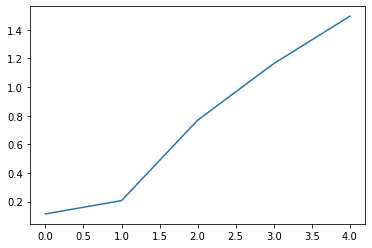

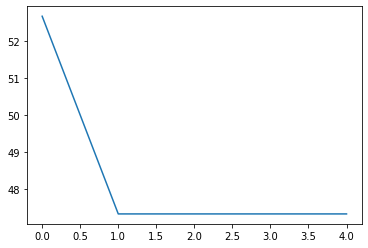



Test set: Average loss: 1.5383, Accuracy: 150/317 (47%)



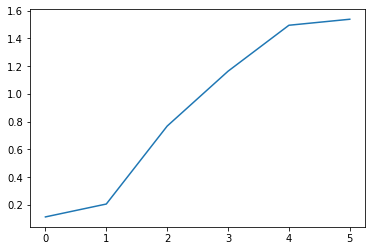

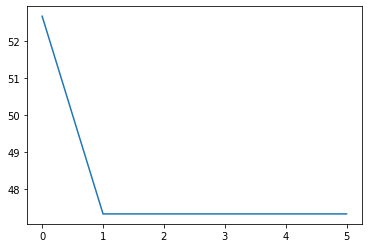



Test set: Average loss: 1.5295, Accuracy: 150/317 (47%)



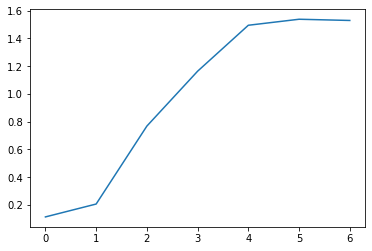

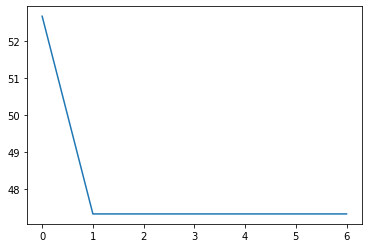



Test set: Average loss: 1.3043, Accuracy: 150/317 (47%)



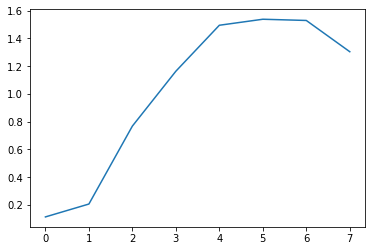

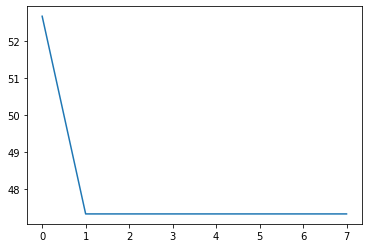



Test set: Average loss: 1.4126, Accuracy: 150/317 (47%)



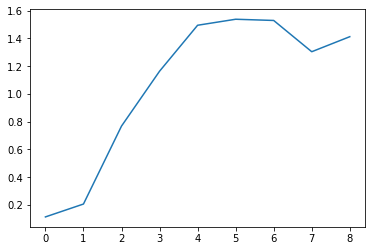

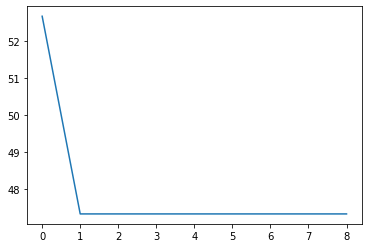



Test set: Average loss: 1.3833, Accuracy: 150/317 (47%)



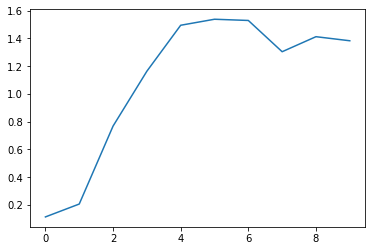

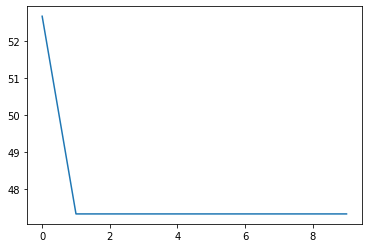



Test set: Average loss: 1.3657, Accuracy: 150/317 (47%)



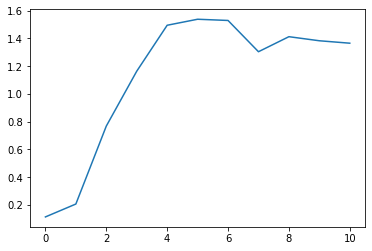

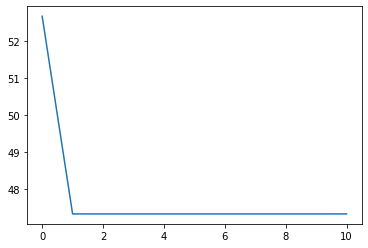



Test set: Average loss: 1.2317, Accuracy: 150/317 (47%)



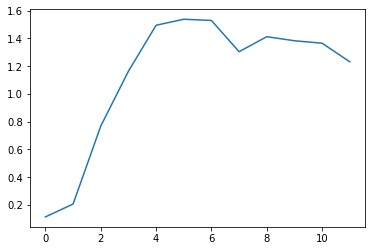

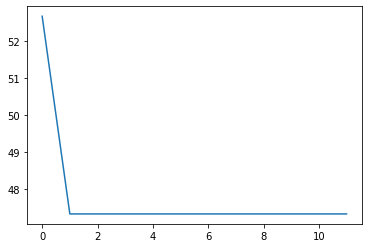



Test set: Average loss: 1.0858, Accuracy: 150/317 (47%)



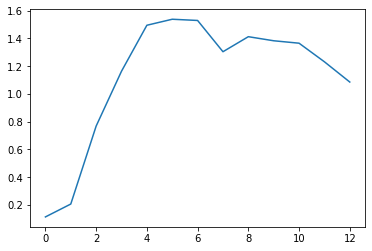

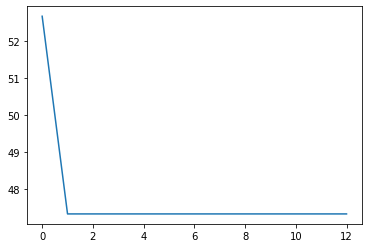



Test set: Average loss: 1.0516, Accuracy: 150/317 (47%)



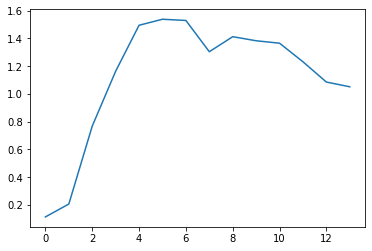

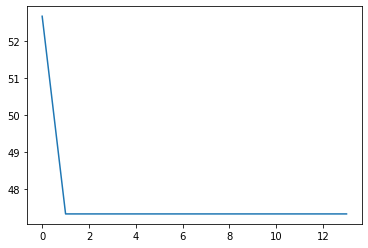



Test set: Average loss: 1.0892, Accuracy: 150/317 (47%)



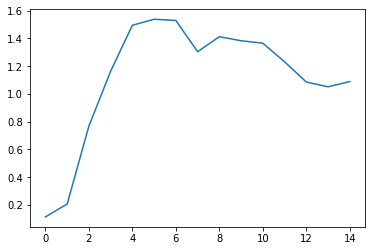

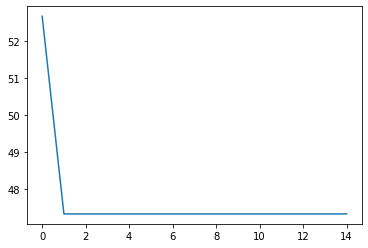



Test set: Average loss: 1.0941, Accuracy: 150/317 (47%)



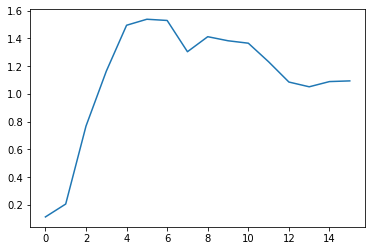

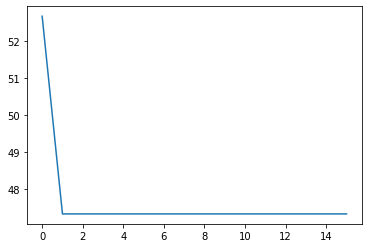



Test set: Average loss: 1.0131, Accuracy: 150/317 (47%)



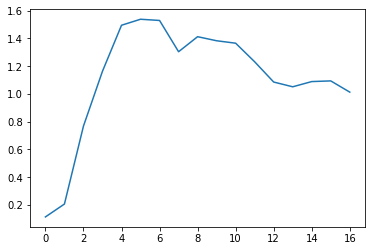

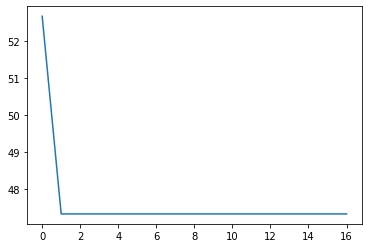



Test set: Average loss: 0.9769, Accuracy: 150/317 (47%)



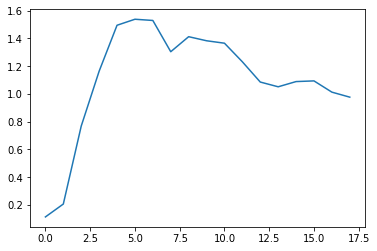

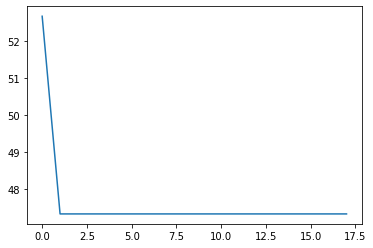



Test set: Average loss: 0.8540, Accuracy: 150/317 (47%)



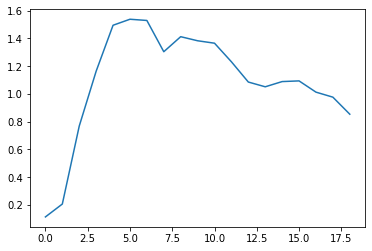

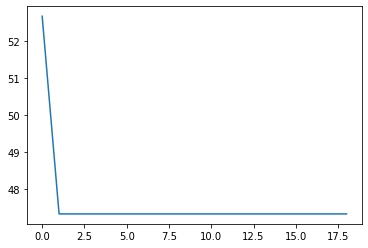



Test set: Average loss: 0.8105, Accuracy: 150/317 (47%)



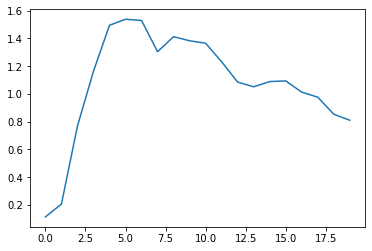

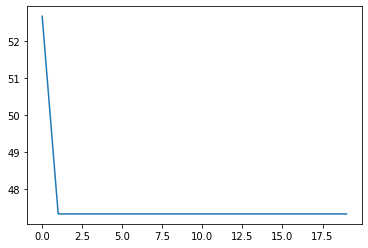



Test set: Average loss: 0.8085, Accuracy: 150/317 (47%)



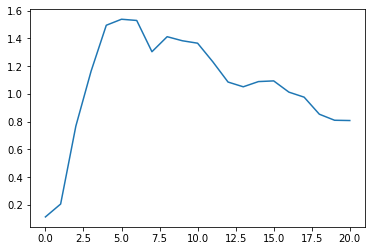

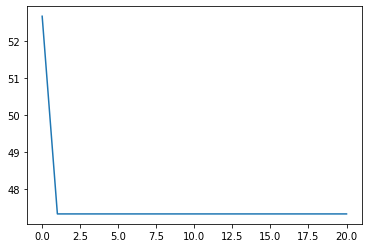



Test set: Average loss: 0.7364, Accuracy: 150/317 (47%)



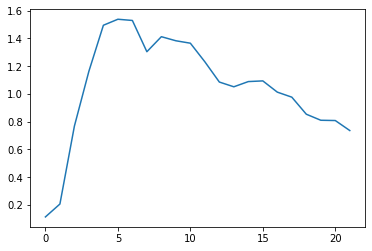

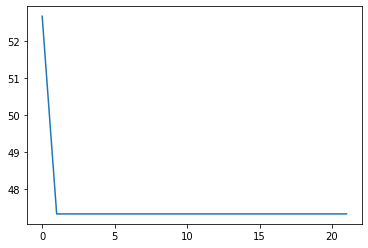



Test set: Average loss: 0.7007, Accuracy: 150/317 (47%)



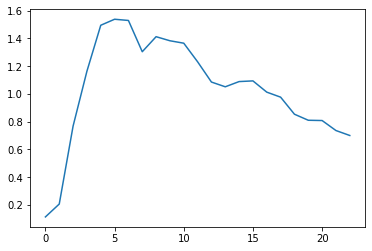

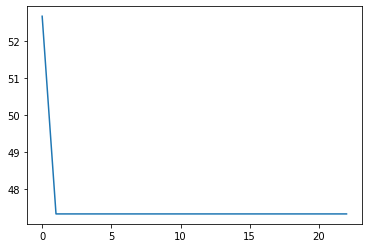



Test set: Average loss: 0.7297, Accuracy: 150/317 (47%)



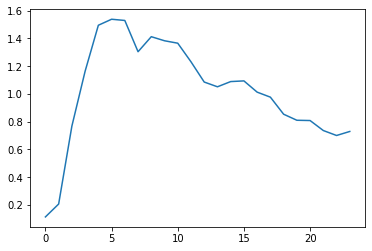

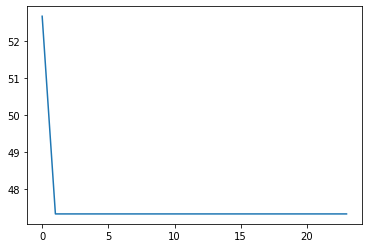



Test set: Average loss: 0.5602, Accuracy: 150/317 (47%)



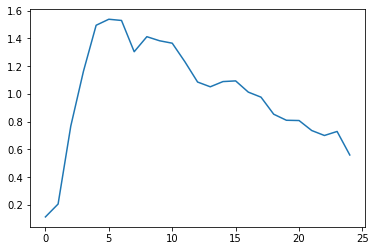

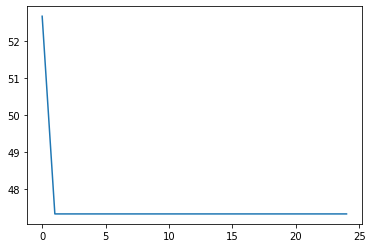



Test set: Average loss: 0.5982, Accuracy: 150/317 (47%)



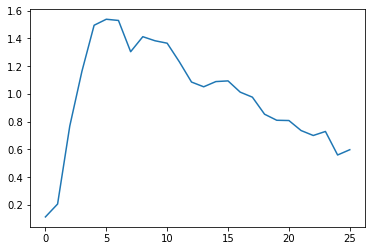

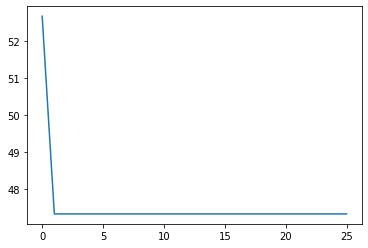



Test set: Average loss: 0.5566, Accuracy: 150/317 (47%)



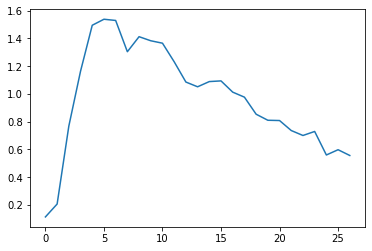

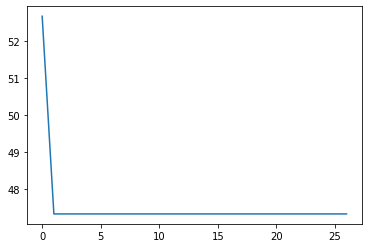



Test set: Average loss: 0.5951, Accuracy: 150/317 (47%)



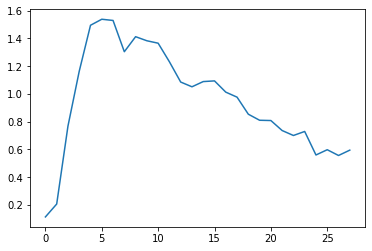

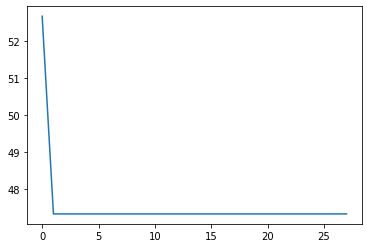



Test set: Average loss: 0.5910, Accuracy: 150/317 (47%)



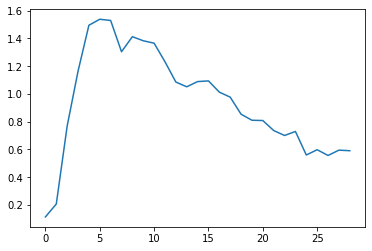

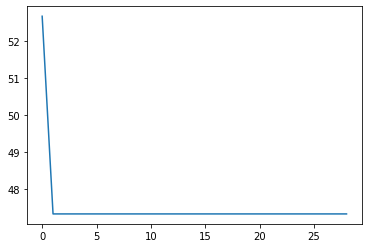

KeyboardInterrupt: ignored

In [ ]:
for epoch in tqdm(range(1, epochs + 1), desc = "Total Training Progress"):

    for unsup_data, _ in tqdm(unsup_loader, desc="Epoch %d: Training on Unlabeled Data" % epoch):
        dataiter = iter(train_loader)

        labeled_data, labels = dataiter.next()

        # TRAIN THE DISCRIMINATOR (THE CLASSIFIER)
        classifier.train()
        optimizerC.zero_grad()
        
        # 1. on Unlabelled data
        unsup_data = unsup_data.to(device)        
        outputs = classifier(unsup_data)    
        logz_unlabel = log_sum_exp(outputs)
        lossUL = 0.5 * (-torch.mean(logz_unlabel) + torch.mean(F.softplus(logz_unlabel)))
        lossUL.backward()  
        
        # 2. on the generated data

        noise = torch.randn(unsup_batch_size, 100, 1, 1, device=device)
        generated = (netG(noise)+1.0)/2.0
        outputs = classifier(generated.detach()) # detach() because we are not training G here
        logz_fake = log_sum_exp(outputs)
        lossD = 0.5*torch.mean(F.softplus(logz_fake))
        lossD.backward()

        # 3. on labeled data
        labeled_data, labels = labeled_data.to(device), labels.to(device)
        output = classifier(labeled_data)
        logz_label = log_sum_exp(output)
        prob_label = torch.gather(output, 1, labels.unsqueeze(1))
        labeled_loss = -torch.mean(prob_label) + torch.mean(logz_label)
        labeled_loss.backward()    

        optimizerC.step()

        optimizerC.step()
        
        # TRAIN THE GENERATOR
        netG.train()
        optimizerG.zero_grad()
        
        outputs = classifier(generated)
        logz_unlabel = log_sum_exp(outputs)
        lossG = 0.5 * (-torch.mean(logz_unlabel) + torch.mean(F.softplus(logz_unlabel)))
        lossG.backward()
        optimizerG.step()
 
    
    generated = (netG(fixed_noise)+1.0)/2.0
    vutils.save_image(generated.cpu().detach(), 
                      ('/content/gdrive/MyDrive/MBSUS/Training+Testing/Generated Images/generated_%d.jpg' % epoch), normalize=True)
    
    val_loss, val_accuracy = test(classifier, device, val_loader, len_val, True)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
        
    if val_accuracy > best_acc:
        best_acc = val_accuracy
        best_classifier_wts = copy.deepcopy(classifier.state_dict())

    plt.plot(range(len(val_losses)), np.array(val_losses), label = "Val Loss")
    plt.show()
    plt.plot(range(len(val_accuracies)), np.array(val_accuracies), label = "Val Accuracies")
    plt.show()

print('Best VAL test accuracy: ', np.max(np.array(val_accuracies)),
      '% after ', np.argmax(np.array(val_accuracies)), ' training epochs')

# load best model weights
classifier.load_state_dict(best_classifier_wts)

print("\nBest model on the test set: ")
test(classifier, device, test_loader, len_test, True)   

Best VAL test accuracy:  57.09779179810725 % after  66  training epochs

Best model on the test set: 


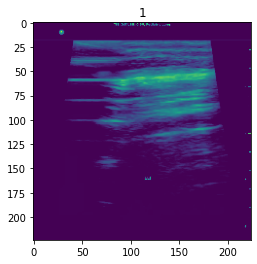

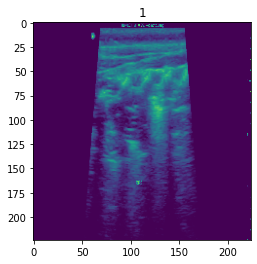

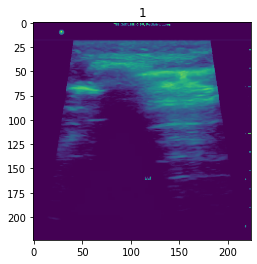

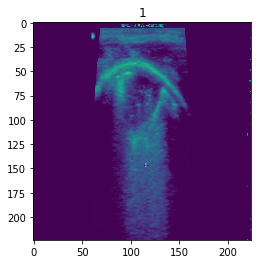

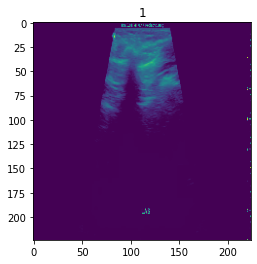

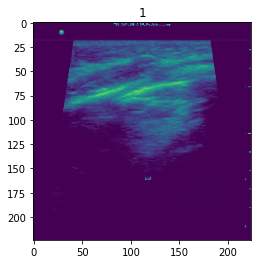

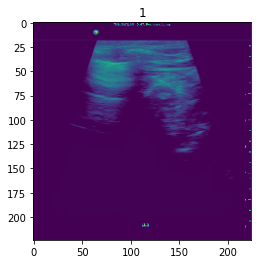

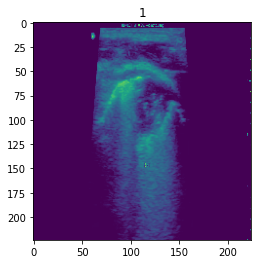

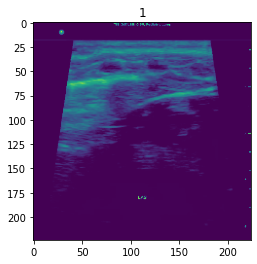

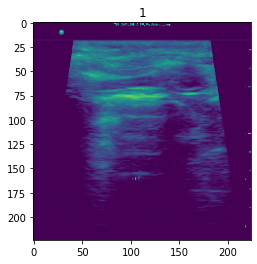

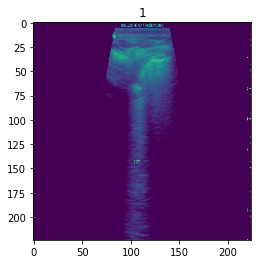

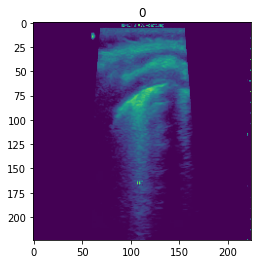

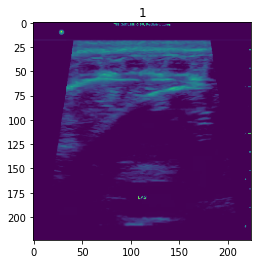

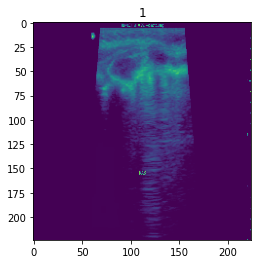

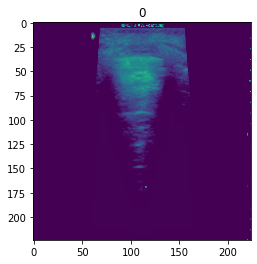

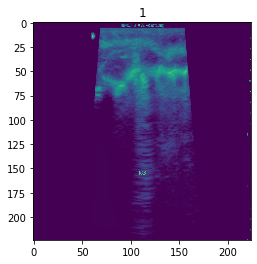

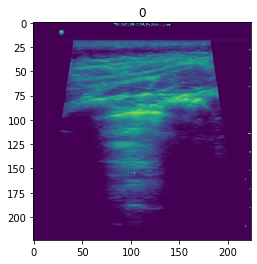

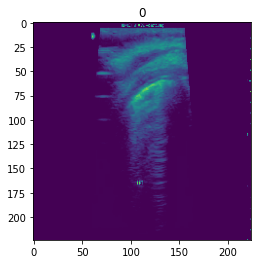

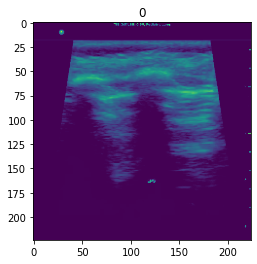

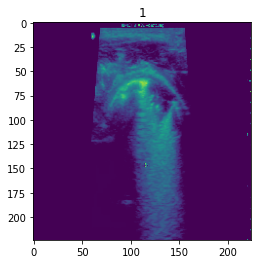

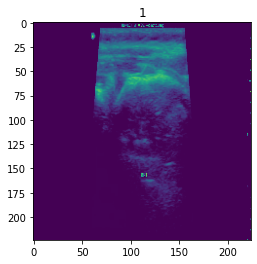

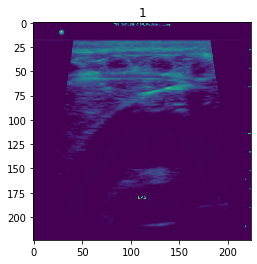

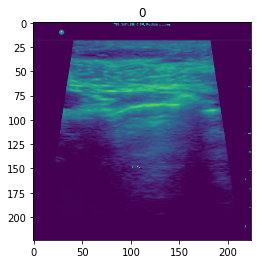

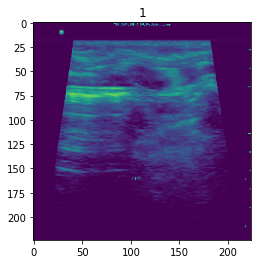

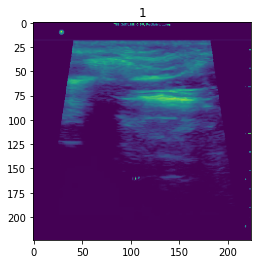

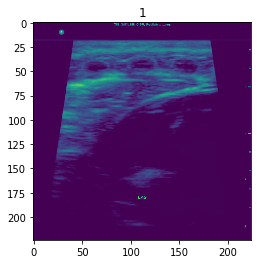

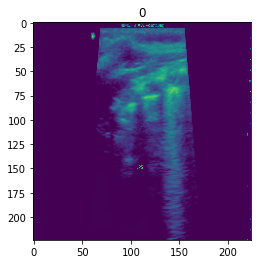

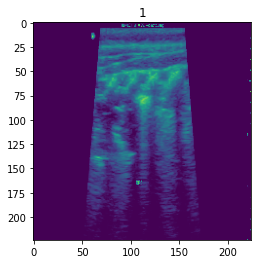

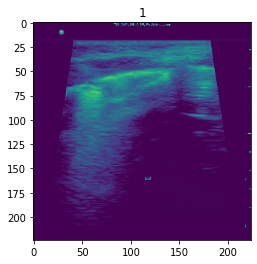

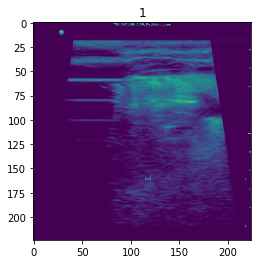

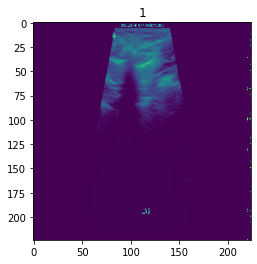

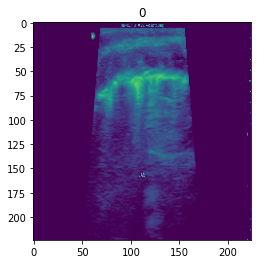

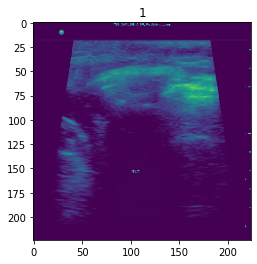

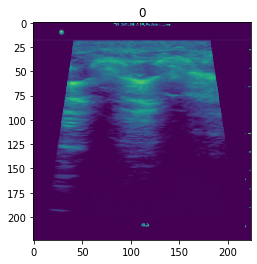

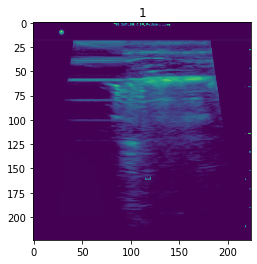

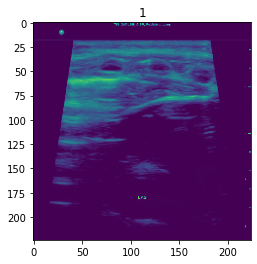

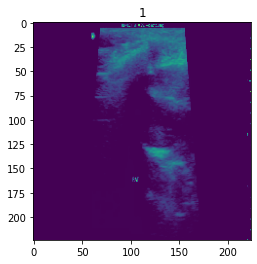

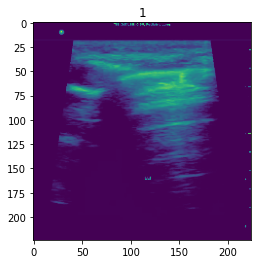

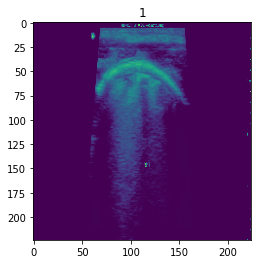

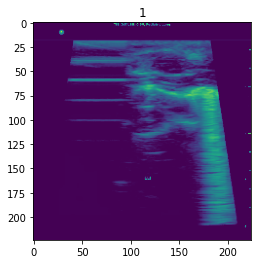

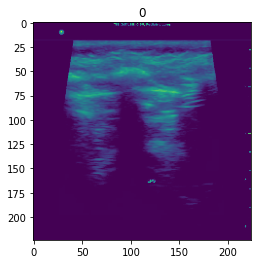

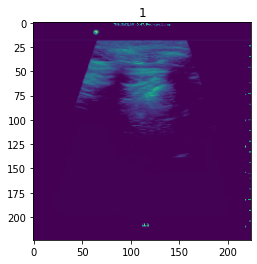

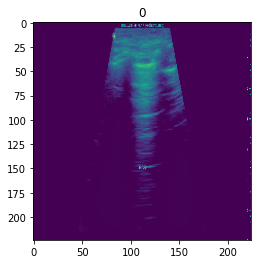

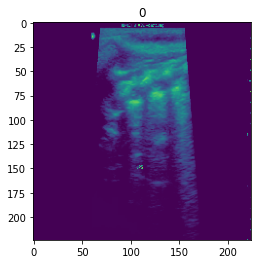

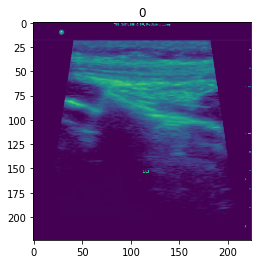

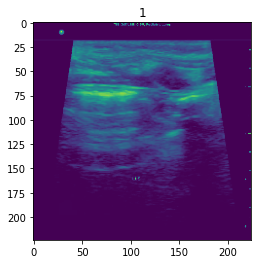

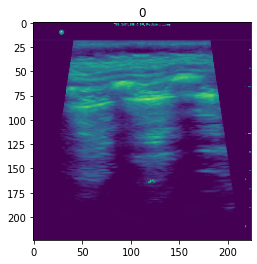

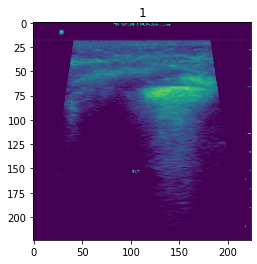

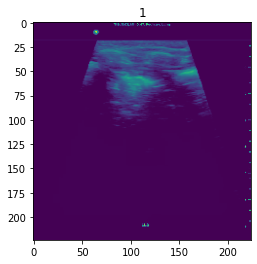

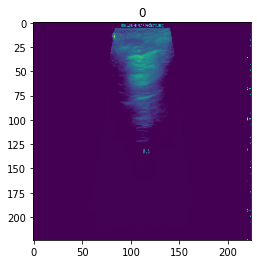

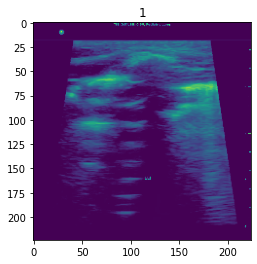

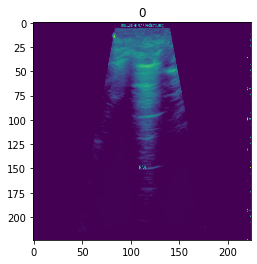

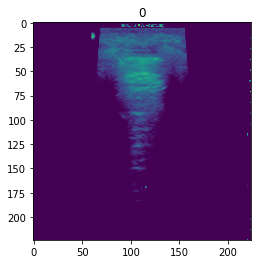

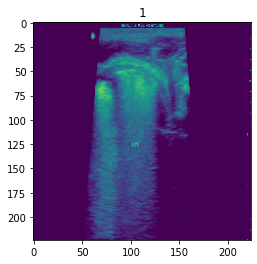

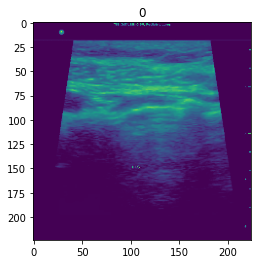

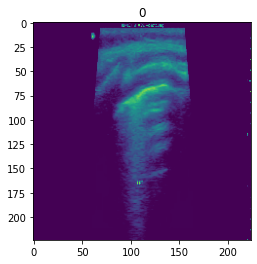

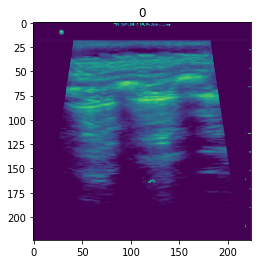

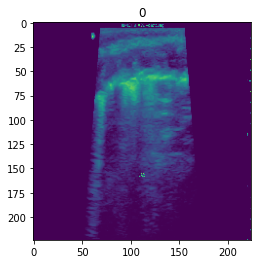

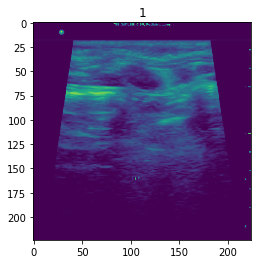

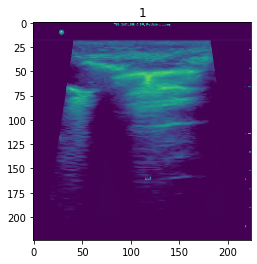

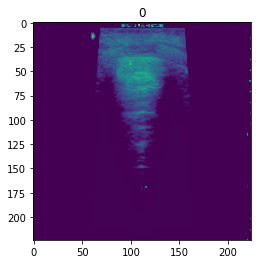

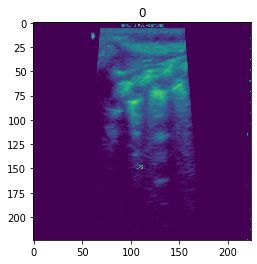

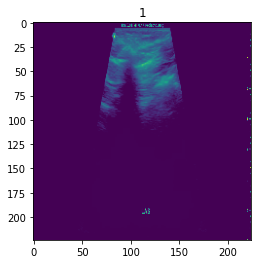

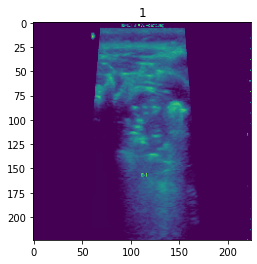

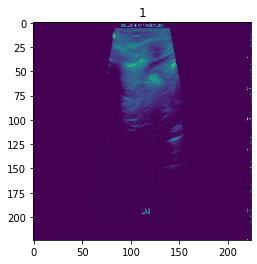

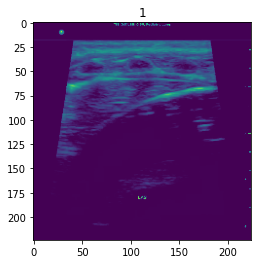

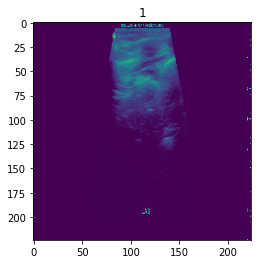

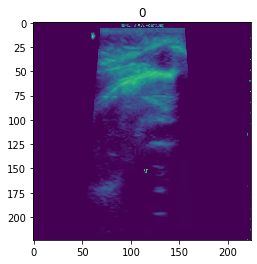

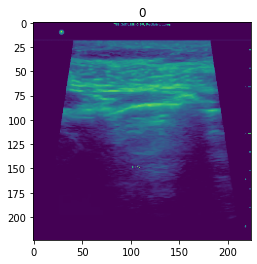

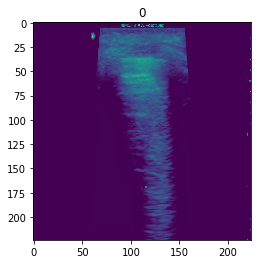

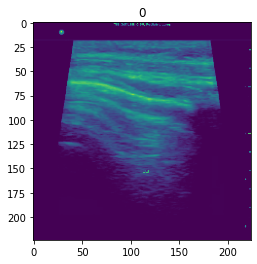

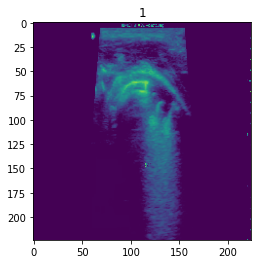

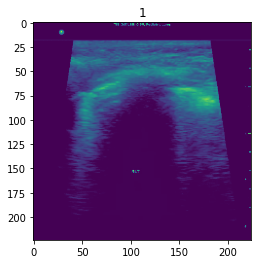

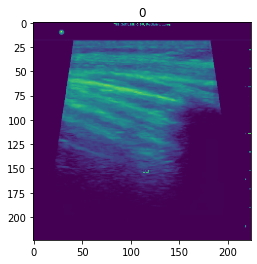

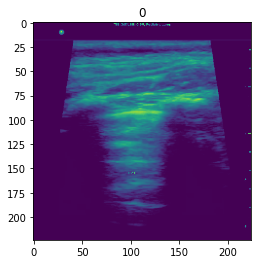

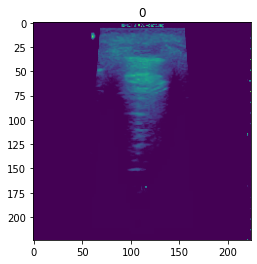

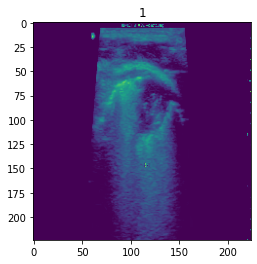

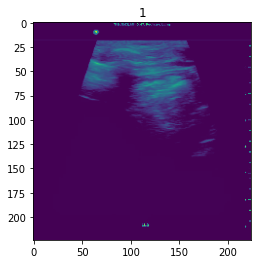

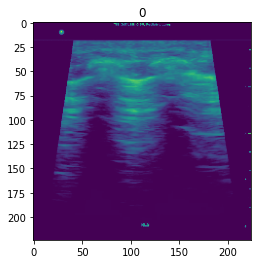

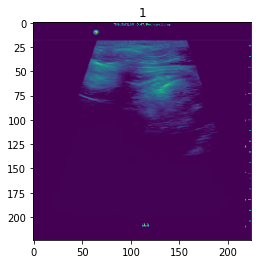

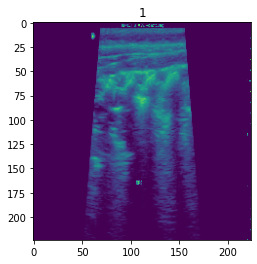

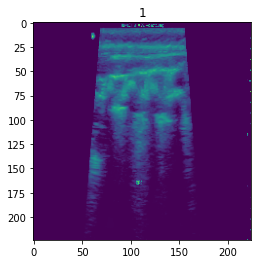

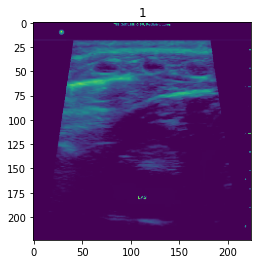

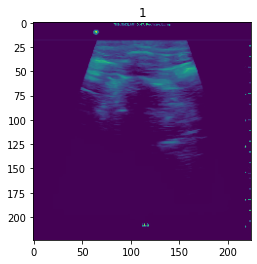

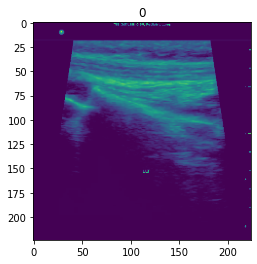

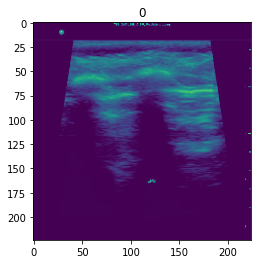

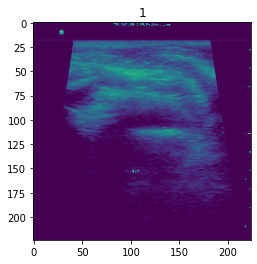

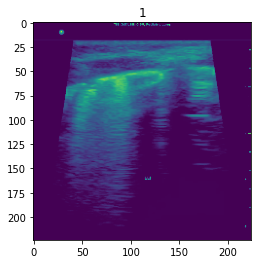


Test set: Average loss: 0.0086, Accuracy: 88/158 (56%)



(0.008576292025892041, 55.69620253164557)

In [ ]:
print('Best VAL test accuracy: ', np.max(np.array(val_accuracies)),
      '% after ', np.argmax(np.array(val_accuracies)), ' training epochs')

# load best model weights
classifier.load_state_dict(best_classifier_wts)

print("\nBest model on the test set: ")
test(classifier, device, test_loader, len_test, True, True) 

In [ ]:
%cd /content/gdrive/My Drive/MBSUS/

#GEN_PATH = "Pneumonia_Cond_Generator_v2.pt"
CRIT_PATH = "SSGAN_224x224_.pt"

#torch.save(gen, GEN_PATH)
torch.save(classifier, CRIT_PATH)

/content/gdrive/My Drive/MBSUS


#Test on real video Data

In [ ]:
batch_size = 20
out_dir = '/content/gdrive/MyDrive/MBSUS/Frames To Be Analyzed/Frames To Be Analyzed'
dataset = datasets.ImageFolder(out_dir, transform=transform)


data_loader = DataLoader(
    dataset,
    batch_size = batch_size,
    shuffle = True
)

In [ ]:
dataset.class_to_idx

{'Healthy': 0, 'Pneumonia': 1}

In [ ]:
results = test(classifier, device, data_loader, len(dataset), display = True)


Test set: Average loss: 0.2645, Accuracy: 32/170 (19%)



Resources:

https://blog.scaleway.com/semi-supervised/

https://arxiv.org/pdf/1606.03498.pdf